# Footprint the extents of raster input and output for SR-Lite

sync to:
/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/notebooks/footprint_srlite.ipynb


In [78]:
#!rsync /home/pmontesa/code/geoscitools/footprint_srlite.ipynb /adapt/nobackup/people/pmontesa/userfs02/projects/srlite/notebooks/footprint_srlite.ipynb

In [2]:
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import contextily as ctx

import glob
import os

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib
from footprintlib import *

# https://gis.stackexchange.com/questions/375577/how-do-i-write-out-a-mixed-geometry-geodataframe-to-a-geopackage
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

# Set up dictionaries of parameters

#### Build a list of dictionarys with the params needed to footprint raster datasets
_TODO: clean this up a bit_

In [6]:
dict_list = [
    # 3SL Senegal TOAs: /explore/nobackup/projects/3sl/data/VHR
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/3sl/data',
     'data_source': '3sl',
     'image_type': 'VHR',
     'layer_name': 'P1BS', #M1BS
     'search_tail_string': '/**/*P1BS*toa.tif', #'/**/*M1BS*toa.tif'
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # 3SL Senegal CHMs: /explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal/v1
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/products/senegal',
     'data_source': '3sl',
     'image_type': 'v1',
     'layer_name': 'toa.2m_chm', #M1BS
     'search_tail_string': '/**/*toa.2m_chm.tif', #'/**/*M1BS*toa.tif'
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # EVHR TOA: /adapt/nobackup/projects/ilab/projects/srlite/input
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/3sl/data/VHR/SRV',#'/explore/nobackup/people/iluser/projects/srlite/input',#'/panfs/ccds02/nobackup/projects/ilab/projects/srlite',#'/explore/nobackup/projects/ilab/data/srlite/toa',#"/adapt/nobackup/projects/ilab/projects/srlite/input/Serc", #/adapt/nobackup/projects/ilab/projects/srlite/input/Serc
     'data_source': 'Senegal_SRV',#'EVHR',
     'image_type': '**',
     'layer_name': 'M1BS',
     'search_tail_string': '/*M1BS*toa.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal',#'/explore/nobackup/projects/ilab/data/srlite/toa', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # CCDC input: /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL
    {'location': 'local',
     'data_dir': "/explore/nobackup/people/mmacande/srlite/srlite_shared/ccdc_v20221001", #"/explore/nobackup/projects/ilab/data/srlite/ccdc/ccdc_v20220620",#"/panfs/ccds02/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL",#,#,
     'data_source': 'ccdc_v20221001',#'ccdc_v20220620',#'CCDC',#'',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*ccdc.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/ccdc', #'/adapt/nobackup/people/pmontesa/userfs02/_share',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # SR-Lite cloudmasks
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/data/srlite/cloudmask",
     'data_source': 'Cloudmask',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*toa.cloudmask.v1.2.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/projects/ilab/data/srlite/cloudmask',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },

    # SR-lite output
    {'location': 'local',
     #'data_dir': "/adapt/nobackup/projects/ilab/data/srlite/products/srlite-0.9.9-06132022-reproject_ALL_only_once_to_toa",
     #'data_dir': "/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022",
     #'data_dir': "/explore/nobackup/projects/ilab/data/srlite/products/archive/srlite-0.9.15-10282022-qa/10282022-all",
     'data_dir': "/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all",
     'data_source': 'srlite-0.9.14',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*sr-02m.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/srlite',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NEON Lidar: This gets ALL DSM.tif files across NEON archive
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products", #/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar
     'data_source': 'DSM',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/**/*DSM.tif',#'/*DSM.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NEON Derived Forest Structure Data (FSD): This gets ALL CHM.tif files across NEON archive that Glenn has processed so far
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/FSD", #/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar
     'data_source': 'CHM',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/**/*CHM.tif',#'/*DSM.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # SSURGO layers grabbed using planetary_computer subsetting tool (1 SSURGO layer represents the whole stack)
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/data/AGB/SSURGO/MLBS/2020-07-01",
     'data_source': 'SSURGO_aws0_150_conus',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/**/aws0_150_conus_*.tif',#'/*DSM.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # AmigaCarb GLiHT 2012
    # 
    {'location': 'local',
     'data_dir': "/explore/nobackup/projects/ilab/projects/AIML_CHM/CNN_CHM/data/GLiHT/Howland/AMIGACarb_Bangor_FIA_Jun2012",
     'data_source': 'AMIGACARB_2012_BangorCHM',
     'image_type': '**',
     'layer_name': 'all',
     'search_tail_string': '/*CHM.tif',#'/*DSM.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/above_icesat2/misc/validation_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
]

### Select a dict from the list


In [7]:
######################
# Select a dictionary
d = dict_list[2]
TEST=False
######################
d

{'location': 'local',
 'data_dir': '/explore/nobackup/projects/3sl/data/VHR/SRV',
 'data_source': 'Senegal_SRV',
 'image_type': '**',
 'layer_name': 'M1BS',
 'search_tail_string': '/*M1BS*toa.tif',
 'search_link_string': '',
 'GET_BATCH': True,
 'DO_DATAMASK': False,
 'GET_ONLY_DATASETMASK': True,
 'MANY_CRS': True,
 'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal',
 'footprint_name_SPLIT_CHAR': '_',
 'footprint_name_SPLIT_POS': 0,
 'aws_credential_fn': None}

### Run the footprinting code over a list  
return:
1. a geodataframe  
2. a geopackage **updated** 

notes:  
https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [17]:
%%time

footprint_gdf_list = list() 

layer_name = d['layer_name']
    
#filename = 'footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'
filename = 'footprints_' + d['data_source']+'.gpkg'

#SEARCH_STR_LIST = ["/", sensor, image_type, ".tif"]
SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
keystring = d['search_link_string'].join(SEARCH_STR_LIST)
print(d['data_dir'] + keystring)

# Raster list
if d['location'] == 'local':
    r_fn_list = glob.glob(d['data_dir'] + keystring, recursive=True)
else:
    print('on s3...')
    r_fn_list = s3.glob(d['data_dir'] + keystring)
    r_fn_list = ['s3://' + f for f in r_fn_list]

if TEST:
    r_fn_list = r_fn_list[0:2]
    print(r_fn_list)
    filename = 'TEST_footprints_' + d['data_source']+'_'+d['image_type']+'.gpkg'

outprint_fn = os.path.join(d['out_footprint_dir'], filename)

print(f'{len(r_fn_list)} total inputs from ' + d['data_source'] )   

if d['location'] == 'local':
    # Raster files are local
    # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
    f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r', MANY_CRS=d['MANY_CRS']) for r_fn in r_fn_list]
if d['location'] == 's3':
    # Raster files are on s3
    # Get the rio AWS session needed to access the s3 rasters in order to footprint
    aws_session = get_rio_aws_session_from_creds(d['aws_credential_fn'])
    with rio.Env(aws_session):
        # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
        f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
        
if len(f_gdf_lst)==0:
    print('\nNothing was footprinted.\n')
else:
    # Build a footprint database geodataframe from all rasters
    footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=True, OUT_F_NAME=outprint_fn, OUT_LYR_NAME=layer_name, DROP_DUPLICATES=True)
    footprint_gdf['footprint_name'] = footprint_gdf['file'].str.split(d['footprint_name_SPLIT_CHAR'], expand=True)[d['footprint_name_SPLIT_POS']]
    if d['GET_BATCH']:
        footprint_gdf['batch_name'] = footprint_gdf['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    footprint_gdf_list.append(footprint_gdf)


/explore/nobackup/projects/3sl/data/VHR/SRV/**/*M1BS*toa.tif
714 total inputs from Senegal_SRV
Building GDF from list...
Wrote out spatial footprints to /explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal/footprints_Senegal_SRV.gpkg
CPU times: user 5.59 s, sys: 2.07 s, total: 7.66 s
Wall time: 31.7 s


In [18]:
footprint_gdf.head()

,geometry,footprint_name,path,file,area_km2,area_ha,batch_name
0,"POLYGON ((-14.85822 16.45006, -14.85799 16.764...",WV02,/explore/nobackup/projects/3sl/data/VHR/SRV/M1BS,WV02_20150414_M1BS_1030010040537B00-toa.tif,682.410288,68241.0288,M1BS
1,"POLYGON ((-16.36060 15.92483, -16.36209 16.144...",WV02,/explore/nobackup/projects/3sl/data/VHR/SRV/M1BS,WV02_20110729_M1BS_103001000C9DF200-toa.tif,426.426880,42642.6880,M1BS
2,"POLYGON ((-16.36931 15.91944, -16.37123 16.200...",WV02,/explore/nobackup/projects/3sl/data/VHR/SRV/M1BS,WV02_20160107_M1BS_103001004FD70300-toa.tif,719.661152,71966.1152,M1BS
3,"POLYGON ((-14.39922 16.19894, -14.39768 16.698...",WV02,/explore/nobackup/projects/3sl/data/VHR/SRV/M1BS,WV02_20130304_M1BS_1030010020138400-toa.tif,1013.502952,101350.2952,M1BS
4,"POLYGON ((-15.13552 16.19884, -15.13591 16.763...",WV02,/explore/nobackup/projects/3sl/data/VHR/SRV/M1BS,WV02_20170501_M1BS_1030010067D2B600-toa.tif,1129.865220,112986.5220,M1BS


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


711
611


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


714


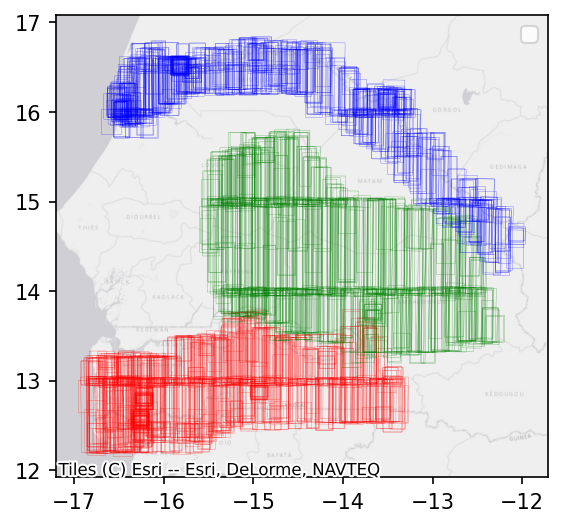

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(6,4)) 
SITE_OUTLINES = ['red', 'green', 'blue'] 
Senegal_SITES = ['CAS', 'ETZ', 'SRV']
GDF_LIST = []

for i, SITE in enumerate(Senegal_SITES):
    
    footprint_gdf = gpd.read_file(f'/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal/footprints_Senegal_{SITE}.gpkg')
    footprint_gdf['batch_name'] = SITE
    GDF_LIST.append(footprint_gdf)
    
    n_strips = footprint_gdf.shape[0]
    print(n_strips)
    ax = footprint_gdf.boundary.to_crs(4326).plot(ax=ax, ec=SITE_OUTLINES[i], linewidth=0.1)
    ax.legend()
    
footprint_gdf = pd.concat(GDF_LIST)
    
ax = ctx.add_basemap(ax, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    

In [12]:
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='file', LAYER_NAME = 'Senegal SR-Lite footprints', zoom_start=6, 
                        lon_start = footprint_gdf.geometry.centroid.x.mean(), 
                        lat_start = footprint_gdf.geometry.centroid.y.mean(), 
                        fig_h=350)

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_711791/2819551641.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon_start = footprint_gdf.geometry.centroid.x.mean(),
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_711791/2819551641.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat_start = footprint_gdf.geometry.centroid.y.mean(),


In [ ]:
# Get acq year for NEON DSM files
#
footprint_gdf.shape
#footprint_gdf['acq_year'] = footprint_gdf['path'].apply(lambda x: x.split('/')[10])
footprint_gdf.tail()
#out_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg'
#footprint_gdf.to_file(out_fn, driver='GPKG')

In [ ]:
# toa_list = (footprint_gdf.path + '/' + footprint_gdf.file).to_list()
# z = pd.concat([make_vhr_xml_dataframe(toa_fn.replace('tif','xml')) for toa_fn in toa_list])

### Summarize the footprints gdf

In [7]:
#footprint_gdf = gpd.read_file('/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprints_srlite-0.9.9.gpkg')
footprint_gdf['batch_name'] = footprint_gdf['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
footprint_gdf[footprint_gdf.batch_name == 'Howland-WV02'].total_bounds
#footprint_gdf.bounds

array([nan, nan, nan, nan])

In [27]:
print(f"Total # of {d['data_source'] } files:  {footprint_gdf.shape[0]}")
footprint_gdf[['footprint_name','batch_name','path']].groupby(['batch_name','footprint_name']).count()


Total # of Cloudmask files:  336


path
batch_name     footprint_name      
Alaska         GE01              26
               QB02               4
               WV02             122
               WV03              21
Fairbanks      WV02               9
               WV03               3
Howland        GE01               4
               WV02               7
               WV03               1
Laselva        GE01               7
               QB02               8
RailroadValley WV02              50
Senegal        WV02              27
               WV03               3
Siberia        WV02              25
               WV03               2
Whitesands     QB02               8
               WV02               7
Yukon_Delta    WV02               2

## Check all footprints

In [12]:
FOOTPRINT_TYPE_LIST = ['EVHR','ccdc_v20220620','Cloudmask']
smry_df_list = []
footprint_gdf_LIST = []
for i,TYPE in enumerate(FOOTPRINT_TYPE_LIST):
    footprint_fn = f"{dict_list[i]['out_footprint_dir']}/footprints_{TYPE}.gpkg"
    print(footprint_fn)
    footprint_gdf_TYPE = gpd.read_file(footprint_fn)
    
    print(f"Total # of {dict_list[i]['data_source'] } files:  {footprint_gdf_TYPE.shape[0]}")
    
    footprint_gdf_TYPE = footprint_gdf_TYPE[~footprint_gdf_TYPE.file.str.contains("_P1BS_")]
    print(f"Total # of {dict_list[i]['data_source'] } M1BS files:  {footprint_gdf_TYPE.shape[0]}")
    
    footprint_gdf_TYPE['footprint_type'] = TYPE
    footprint_gdf_TYPE['batch_name'] = footprint_gdf_TYPE['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    footprint_gdf_TYPE['sensor'] = footprint_gdf_TYPE['file'].str.split('_', expand=True)[0]
    footprint_gdf_LIST.append(footprint_gdf_TYPE)
    #print(footprint_gdf_TYPE[['file','batch_name','path','footprint_type']].groupby(['footprint_type']).count())
    smry_df = footprint_gdf_TYPE[['file','batch_name','path','footprint_type']].groupby(['batch_name','path','footprint_type']).count()
    smry_df_list.append(smry_df)
    
footprint_gdf_ALL = pd.concat(footprint_gdf_LIST)    
smry_df = pd.concat(smry_df_list)
smry_df_fn = '/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprint_smry.csv'
print(f"Summary file: {smry_df_fn}")
smry_df.to_csv(smry_df_fn)
smry_df

/explore/nobackup/projects/ilab/data/srlite/toa/footprints_EVHR.gpkg
Total # of EVHR files:  367
Total # of EVHR M1BS files:  367
/explore/nobackup/projects/ilab/data/srlite/ccdc/footprints_ccdc_v20220620.gpkg
Total # of ccdc_v20220620 files:  452
Total # of ccdc_v20220620 M1BS files:  452
/explore/nobackup/projects/ilab/data/srlite/cloudmask/footprints_Cloudmask.gpkg
Total # of Cloudmask files:  336
Total # of Cloudmask M1BS files:  336
Summary file: /adapt/nobackup/people/pmontesa/userfs02/projects/srlite/footprint_smry.csv


,,,file
batch_name,path,footprint_type,
Alaska,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska,EVHR,176
Howland,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Howland,EVHR,12
Laselva,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Laselva,EVHR,15
RailroadValley,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/RailroadValley,EVHR,50
Senegal,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Senegal,EVHR,30
Serc,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Serc,EVHR,40
Siberia,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Siberia,EVHR,27
Whitesands,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Whitesands,EVHR,15
Yukon_Delta,/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Yukon_Delta,EVHR,2


In [28]:
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='file', LAYER_NAME = d['data_source'], zoom_start=6, 
                        #lon_start=footprint_gdf[footprint_gdf.batch_name == 'Senegal'].geometry.centroid.x.mean(), 
                        #lat_start=footprint_gdf[footprint_gdf.batch_name == 'Senegal'].geometry.centroid.y.mean(), 
                        fig_h=350)

In [76]:
maplib.MAP_LAYER_FOLIUM(gpd.read_file('/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/misc/footprints_srlite-0.9.9.gpkg'),
                        LAYER_COL_NAME='file', foliumMap = None, zoom_start=2, lon_start=0, fig_h=350,
                        LAYER_NAME = 'SR-Lite',
                        LAYER_STYLE_DICT = {'fillColor': 'black', 'color': 'blue', 'weight' : 0.75, 'opacity': 1, 'fillOpacity': 0.5})